In [168]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sin, cos,pi,sqrt,abs,real,imag,exp,conjugate

In [169]:
#RK4Solver class
class RK4Solver:

  def __init__(self, s_i, dt,t0,time,ndim, system_of_equations):
    self.dt = dt
    self.t0 = t0
    self.time = time
    self.s = s_i
    self.system_of_equations = system_of_equations
    self.ndim = ndim
    self.steps = int(self.time/self.dt)
    self.state_solution = np.zeros((self.ndim,self.steps))
    self.time_solution = np.zeros((1, self.steps))
    self.index = 0;

    #taking single step RK4
  def RK4Step(self,s, dt, t, derivs):
      f1 = derivs(s, t)
      f2 = derivs(s+f1*dt/2.0, t+dt/2.0)
      f3 = derivs(s+f2*dt/2.0, t+dt/2.0)
      f4 = derivs(s+f3*dt, t+dt)
      return s + (f1+2*f2+2*f3+f4)*dt/6.0

  def Run_solver(self):
    for step in  range(self.steps):
      
      self.time_solution[0][self.index] = self.t0
      for i in range(self.ndim):
        self.state_solution[i][self.index] = self.s[i].item()

      self.s = self.RK4Step(self.s, self.dt, self.time, self.system_of_equations)
      self.t0 = self.t0 + self.dt
      self.index = self.index+1
      
    return np.array([self.state_solution,self.time_solution])

In [170]:
def dq0_abc_transform(v_d,v_q,v_0,wt):
  one = 1
  a = cos(wt)*v_d - sin(wt)*v_q + one*v_0
  b = cos(wt-2*pi/3)*v_d -sin(wt-2*pi/3)*v_q + one*v_0
  c = cos(wt+2*pi/3)*v_d -sin(wt+2*pi/3)*v_q + one*v_0
  return np.array([a,b,c])

In [171]:
def abc_to_dq0(va,vb,vc,wt):
  V_d = (2/3)*(va*sin(wt) + vb*sin(wt-2*pi/3) + vc*sin(wt+2*pi/3))
  V_q = (2/3)*(va*cos(wt) + vb*cos(wt-2*pi/3) + vc*cos(wt+2*pi/3))
  V_0 = (1/3)*(va + vb+vc)
  return np.array([V_d,V_q,V_0])

In [172]:
Base_inv_va = 10000
Base_v_dc = 800
Base_V_phase = Base_v_dc/(2*sqrt(3)) # for SPWM
Base_v_peak = sqrt(2)*Base_V_phase
Base_i = Base_inv_va/(3*Base_V_phase)
Base_i_peak = sqrt(2)*Base_i
f_base = 50
omega_base = 2*pi*f_base
poles = 2
omega_m_base = omega_base*(2/poles)
Z_sbase = Base_V_phase*1000/Base_i
Torque_base = Base_V_phase*1000/omega_m_base
Base_flux_linkage = Base_v_peak*1000/(omega_base)
Base_inductance = Z_sbase/omega_base
Base_resistance = Z_sbase

<h2>Virtual Synchronous Machine Modelling</h2>
<h3>Virtual Synchronous Machine Modelling Equations</h3>

$$J\frac{d\omega}{dt} = T_{set} - T_e + D_p (\omega_r - \omega)$$
$$\frac{d\theta}{dt} = \omega$$

$$K\frac{dm_fi_f}{dt} = Q_{set} -Q_e - D_q(V_{ref} - V_t)$$
$$P_{e} = \omega m_fi_f[i_asin\theta + i_bsin(\theta - 2\pi/3) + i_csin(\theta + 2\pi/3)]$$
$$Q_{e} = - \omega m_fi_f[i_acos\theta + i_bcos(\theta - 2\pi/3) + i_ccos(\theta + 2\pi/3)]$$
$$e_{abc} = \omega m_fi_f[sin\theta + sin(\theta - 2\pi/3) + sin(\theta + 2\pi/3)]$$
$$i_{abc} = dq02abc(i_{dq,inv})$$
$$m_d,m_q,m_0 = abc2dq0(e_{abc})$$
$$V_t = \sqrt{V_{d,inv}^2 + V_{q,inv}^2}$$

<h3>Inverter Modelling Equations</h3>
The circuit equations of the voltage source converter as shoen below. The converter with L-type filter has been analysised. The further assumption is to neglet DC side swithching losses since thery are not relevant for grid dynamics/interaztion. Thus it simplifes the dynamics of the DC side of the VSC.

use the eabc to md mq tranport lag

$$\frac{m_dV_{dc}}{2} = L_f\frac{di_{d,inv}}{dt} - ω_sL_fi_{q,i} + R_fi_{d,i} + V_{d,i}$$

$$\frac{m_qV_{dc}}{2} = L_f\frac{di_{q,inv}}{dt} + ω_sL_fi_{d,i} + R_fi_{q,i} + V_{q,i}$$

$$C_{dc}\frac{dV_{dc}}{dt} = \frac{P_{pv}-P_{vsc}}{V_{dc}}$$
$$P_{vsc} = (m_dV_{dc}I_d + m_qV_{dc}i_q)/2$$

$V_{d,i}$ and $V_{q,i}$ are the voltage at PCC. $i_{d,i}$ and $i_{q,i}$ are injected currents.$m_d$ and $m_q$ are the modulation indexes in d and q axis. $C_{dc}$ is DC capacitor. $L_f$and $R_f$ are the filter inductance and resistance.


<h3>Load Modelling Equations</h3>

$$i_{d,inv} + ji_{q,inv} = I_{load}$$
$$I_{load} = I_{dload} + jI_{qload}$$
$$Z_{load} = R_{load} + jX_{load}$$
$$V_{load} = I_{load}Z_{load}$$
$$V_{load} = V_{dload} + jV_{qload}$$
$$S_{load} = I_{load}^* V_{load}$$

In [173]:
#machine parameters in pu


omega_ref = 1
V_ref = 1.1
Q_set = 0
T_m = 0



K = 5;
J = 0.1;
D_q = 100/Base_V_phase;
D_p =800/omega_base;


#inverter parameters
L_f = 0.063/Base_inductance
R_f = 5/Base_resistance
P_pv = 0.4
C_dc = 5*10**(-6)
K_pwm = 1
T_pwm = 0.001


R_load = 2
X_load = 0
Load = complex(R_load,X_load)



In [174]:
def system_of_equations(s, t):
  #state variables
    omega = s[0]
    theta = s[1]
    mfif = s[2]
    m_d = s[3]
    m_q = s[4]
    I_di = s[5]
    I_qi = s[6]
    V_dc = s[7]

    
    V_Load = complex(I_di,I_qi)*Load
    #V_Load = complex(V_ref,0)
    V_di = real(V_Load)
    V_qi = imag(V_Load)
    V_t = abs(V_Load)
    

    i_a,i_b,i_c = dq0_abc_transform(I_di,I_qi,0,theta)
    T_ei = mfif*(i_a*sin(theta) + i_b*sin(theta - 2*pi/3) + i_c*sin(theta + 2*pi/3))
    Q = -omega*mfif*(i_a*cos(theta) + i_b*cos(theta - 2*pi/3) + i_c*cos(theta + 2*pi/3))

    e_a,e_b,e_c = omega*mfif* np.array([sin(theta),sin(theta-2*pi/3), sin(theta +2*pi/3)])
    e_d, e_q,e_0 = abc_to_dq0(e_a,e_b,e_c,theta)

    omega_dot = (1/(J)) *(T_m - T_ei + D_p*(omega_ref - omega))
    theta_dot = omega
    mfif_dot = (1/K)*(Q_set - Q - D_q*(V_ref-V_t))
    

    m_d_dot = (1/T_pwm)*(-m_d + K_pwm*(e_d))
    m_q_dot = (1/T_pwm)*(-m_q + K_pwm*(e_q))
    
    I_di_dot = (1/L_f)*((m_d*V_dc/2) + omega_base*L_f*I_qi - R_f*I_di - V_di)
    I_qi_dot =  (1/L_f)*((m_q*V_dc/2) - omega_base*L_f*I_di - R_f*I_qi - V_qi)
    
    P_vsc = (m_d*V_dc*I_di + m_q*V_dc*I_qi)/2
    
    V_dc_dot = (1/C_dc)*((P_pv - P_vsc)/V_dc)

    return np.array([omega_dot, theta_dot,mfif_dot, m_d_dot,m_q_dot,I_di_dot, I_qi_dot, V_dc_dot])

In [175]:
#Initillization of parameters
omega_i = 1
theta_i= 0.0
mfif_i = 0
I_di_i = 0
I_qi_i = 0
V_dc_i = 1
m_d_i = 0
m_q_i = 0

s_i = np.array([omega_i,theta_i,mfif_i,m_d_i,m_q_i,I_di_i, I_qi_i, V_dc_i]) # initial state
dt = 1*10**(-4)
time =10
t0 = 0
ndim = len(s_i)

In [176]:
solver1 = RK4Solver(s_i,dt,t0,time,ndim,system_of_equations)
sol = solver1.Run_solver()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [177]:
def dq0_abc_transform_arr(v_d,v_q,v_0,omega,t_sol):
  wt = omega*np.array(t_sol);
  one = np.ones(len(wt))
  a = cos(wt)*v_d - sin(wt)*v_q + one*v_0
  b = cos(wt-2*pi/3)*v_d -sin(wt-2*pi/3)*v_q + one*v_0
  c = cos(wt+2*pi/3)*v_d -sin(wt+2*pi/3)*v_q + one*v_0
  return np.array([a,b,c])

In [178]:
omega, theta, mfif,m_d,m_q, I_di, I_qi,V_dc = sol[0] 
t = sol[1][0]
j = complex(0,1)

omega = omega*omega_base
I_dqi = I_di+j*I_qi
V_dqs = I_dqi*Load
#V_dqs = np.array([complex(V_ref,0)]*len(t))
V_di = real(V_dqs)
V_qi = imag(V_dqs)
V_t = abs(V_dqs)
p_load = real(V_dqs*conjugate(I_dqi))
q_load = imag(V_dqs*conjugate(I_dqi))

v_0 = np.zeros(len(t))
i_0 = np.zeros(len(t))
abcv = dq0_abc_transform_arr(V_di,V_qi,v_0,omega,t)
abci = dq0_abc_transform_arr(I_di,I_qi,v_0,omega,t)

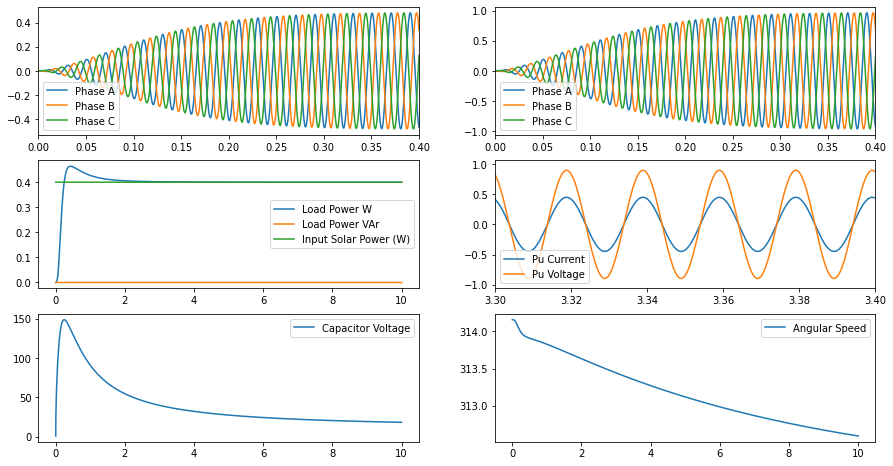

In [179]:
xlimit = [0,0.4]
fig, axs = plt.subplots(3, 2,figsize=(15,8))
axs[0, 0].plot(t,abci[0],label ='Phase A')
axs[0, 0].plot(t,abci[1], label = "Phase B")
axs[0, 0].plot(t,abci[2], label = "Phase C")
axs[0, 0].set_xlim(xlimit)
axs[0, 0].legend()

axs[0, 1].plot(t,abcv[0],label ='Phase A')
axs[0, 1].plot(t,abcv[1], label = "Phase B")
axs[0, 1].plot(t,abcv[2], label = "Phase C")
axs[0, 1].set_xlim(xlimit)
axs[0, 1].legend()

axs[1,0].plot(t,p_load, label= "Load Power W")
axs[1,0].plot(t,q_load, label= "Load Power VAr")
axs[1,0].plot(t,[P_pv]*len(t), label = "Input Solar Power (W)")
axs[1,0].legend()

axs[1,1].plot(t,abci[0], label = "Pu Current")
axs[1,1].plot(t,abcv[0], label = "Pu Voltage")
axs[1,1].legend()
axs[1,1].set_xlim([3.3,3.4])

axs[2,0].plot(t,V_dc, label = "Capacitor Voltage")
axs[2,0].legend()

axs[2,1].plot(t,omega, label = "Angular Speed")
axs[2,1].legend()